In [19]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import sys
sys.executable

'/cm/shared/apps/conda-environments/python39/bin/python'

In [21]:
import os

In [22]:
import copy

In [23]:
os.environ["OMP_NUM_THREADS"] = "2"

In [24]:
import numpy as np
import scipy as sp
import scipy.linalg as la
import scipy.fft as fft
import matplotlib.pyplot as plt

In [25]:
%matplotlib inline

In [26]:
import json

In [27]:
import evoMPS.tdvp_uniform as tdvp
import evoMPS.tdvp_sandwich as tdvp_s
import evoMPS.dynamics as dyn
import evoMPS.split_step as ss
import evoMPS.tdvp_common as tm
import evoMPS.matmul as mm

In [28]:
import sources.master as mas

In [29]:
import sources.post.overlaps as olaps

## Load parameters and precomputed vacuum state

In [30]:
datadir = "./"
simbase = "direc107/"
simname = "maxD48_dt05RK4"
basedir = datadir + simbase
simdir = basedir + simname + "/"
mom = 0.4864
t = 320
dt = 0.05
# Choose a time when the tracks are well-separated. Check if "P" is same for t \pm 20 to be sure. 

In [31]:
with open(basedir + "/state_params.json", "r") as f:
    state_params = json.load(f)
state_params

{'J': 1.0,
 'hx': 1.1,
 'hz': 0.006,
 'J2': 0.0,
 'J3': 0.0,
 'J4': 0.0,
 'J5': 0.0,
 'hzx': 0.0,
 'D': 40,
 'vac_tol': 1e-10,
 'N': 1000,
 'ortho_2p': True,
 'symmB': False,
 'pkt_numsites': 400,
 'pkt_sigma': 70,
 'pkt_midpt': 200,
 'pad_mid': 0,
 'pad_out': 0,
 'momentum': 0.4864,
 'ex_lvl': 0}

In [32]:
ham = mas.get_ham(state_params["J"], state_params["hx"], state_params["hz"], state_params["J2"], state_params["J3"],
             state_params["J4"], state_params["J5"], state_params["hzx"])

In [33]:
vac = tdvp.EvoMPS_TDVP_Uniform.from_file(basedir + "vac_uniform.npy", ham)

In [34]:
vac.schmidt_sq()**0.5

array([9.63035873e-01+0.j, 2.67835729e-01+0.j, 2.75203516e-02+0.j,
       7.80958833e-03+0.j, 2.62435886e-03+0.j, 7.80889933e-04+0.j,
       2.43042906e-04+0.j, 7.99285229e-05+0.j, 7.34259842e-05+0.j,
       2.33931491e-05+0.j, 2.21734827e-05+0.j, 7.81519337e-06+0.j,
       6.84483072e-06+0.j, 2.33693475e-06+0.j, 2.04141753e-06+0.j,
       7.46880848e-07+0.j, 6.90642785e-07+0.j, 6.36113088e-07+0.j,
       2.30036016e-07+0.j, 2.15321966e-07+0.j, 1.89027847e-07+0.j,
       6.97699052e-08+0.j, 6.57473859e-08+0.j, 5.92661368e-08+0.j,
       2.30176555e-08+0.j, 2.16021929e-08+0.j, 2.01846688e-08+0.j,
       1.71138976e-08+0.j, 7.01398832e-09+0.j, 6.36761748e-09+0.j,
       5.93218579e-09+0.j, 5.85262845e-09+0.j, 5.40467059e-09+0.j,
       2.17997628e-09+0.j, 1.98459251e-09+0.j, 1.88612583e-09+0.j,
       1.85003869e-09+0.j, 1.08568975e-09+0.j, 6.74955210e-10+0.j,
       5.19031007e-10+0.j])

## Load state from simulation data

In [35]:
stepnum = int(t/dt)
stepnum

6400

In [36]:
state = olaps.load_state(simdir + f"state_evo_step{stepnum}.npy", ham=ham)

# Compute overlaps with 2p position basis (naive)
Ignoring momentum-dependence of excitation tensors for now.

In [37]:
ps = [mom]  # Compute overlaps using excitation tensors at these momenta.
num_ex = 2  # Use the first two excitation levels

This is the actual position-basis overlap computation:

In [38]:
psi, _, exlbls, sL, sR, BLs, BRs = olaps.overlap_2p_components_multip(
  state, vac, ps=ps, num_ex=num_ex, ortho=True,
  brute=True, force_pseudo=True, verbose=False,
  return_prep_data=True)

In [39]:
exlbls  # Momentum and excitation number for each excitation-tensor label (final two axes of psi)

[(0.4864, 0), (0.4864, 1)]

In [40]:
psi_fn_comp = simdir + f"psi_comp_2p_nex{num_ex}_t{t}.npz"

In [41]:
# Save the position-basis wavefunction
np.savez_compressed(psi_fn_comp, psi=psi, exlbls=exlbls, BLs=BLs, BRs=BRs)

In [42]:
data = np.load(psi_fn_comp)
psi = data["psi"]
BLs = data["BLs"]
BRs = data["BRs"]
#data_ps = data["exlbls"][:,0]

In [43]:
psi.shape

(1001, 1001, 2, 2)

In [44]:
la.norm(np.nan_to_num(psi))

0.4523946603798224

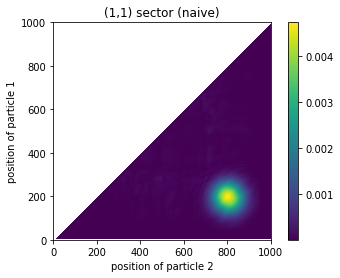

In [45]:
plt.imshow(abs(psi[:,:,0,0]), origin='lower')
plt.title("(1,1) sector (naive)")
plt.xlabel("position of particle 2")
plt.ylabel("position of particle 1")
plt.colorbar()

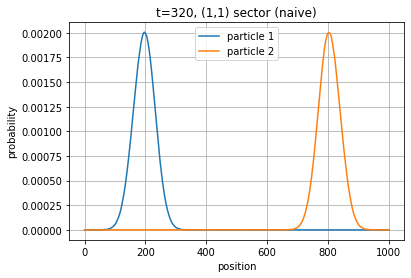

In [46]:
psi_nn = np.nan_to_num(psi)
plt.plot([np.sum(abs(psi_nn[i,:,0,0])**2) for i in range(psi.shape[0])], label="particle 1")
plt.plot([np.sum(abs(psi_nn[:,i,0,0])**2) for i in range(psi.shape[1])], label="particle 2")
plt.legend()
plt.title(f"t={t}, (1,1) sector (naive)")
plt.xlabel("position")
plt.ylabel("probability")
plt.grid()

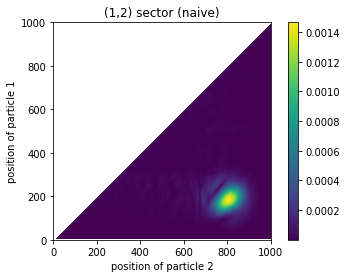

In [47]:
plt.imshow(abs(psi[:,:,0,1]), origin='lower')
plt.title("(1,2) sector (naive)")
plt.xlabel("position of particle 2")
plt.ylabel("position of particle 1")
plt.colorbar()

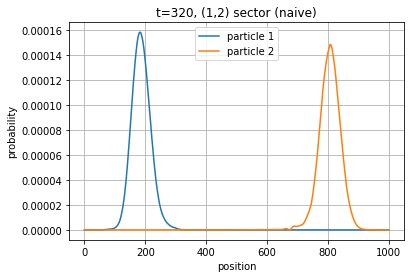

In [48]:
psi_nn = np.nan_to_num(psi)
plt.plot([np.sum(abs(psi_nn[i,:,0,1])**2) for i in range(psi.shape[0])], label="particle 1")
plt.plot([np.sum(abs(psi_nn[:,i,0,1])**2) for i in range(psi.shape[1])], label="particle 2")
plt.legend()
plt.title(f"t={t}, (1,2) sector (naive)")
plt.xlabel("position")
plt.ylabel("probability")
plt.grid()

In [49]:
sum([i * np.sum(abs(psi_nn[i,:,0,1])**2) for i in range(psi.shape[0])])/la.norm(psi_nn[:,:,0,1])**2

187.1979263482232

In [50]:
sum([i * np.sum(abs(psi_nn[:,i,0,1])**2) for i in range(psi.shape[1])])/la.norm(psi_nn[:,:,0,1])**2

805.368712493908

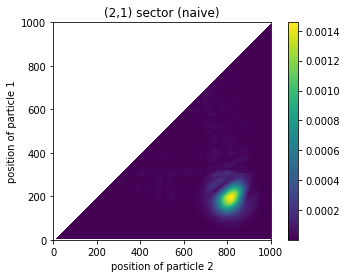

In [51]:
plt.imshow(abs(psi[:,:,1,0]), origin='lower')
plt.title("(2,1) sector (naive)")
plt.xlabel("position of particle 2")
plt.ylabel("position of particle 1")
plt.colorbar()

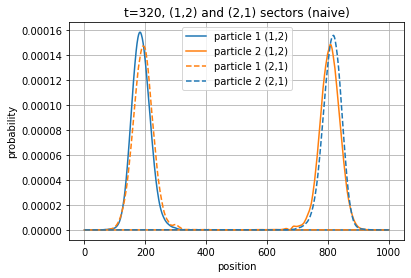

In [52]:
psi_nn = np.nan_to_num(psi)
plt.plot([np.sum(abs(psi_nn[i,:,0,1])**2) for i in range(psi.shape[0])], "C0-", label="particle 1 (1,2)")
plt.plot([np.sum(abs(psi_nn[:,i,0,1])**2) for i in range(psi.shape[1])], "C1-", label="particle 2 (1,2)")
plt.plot([np.sum(abs(psi_nn[i,:,1,0])**2) for i in range(psi.shape[0])], "C1--", label="particle 1 (2,1)")
plt.plot([np.sum(abs(psi_nn[:,i,1,0])**2) for i in range(psi.shape[1])], "C0--", label="particle 2 (2,1)")
plt.legend()
plt.title(f"t={t}, (1,2) and (2,1) sectors (naive)")
plt.xlabel("position")
plt.ylabel("probability")
plt.grid()

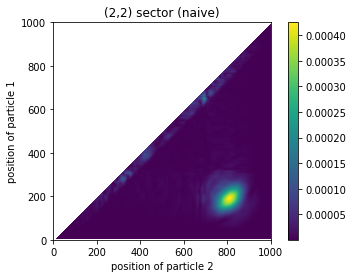

In [53]:
plt.imshow(abs(psi[:,:,1,1]), origin='lower')
plt.title("(2,2) sector (naive)")
plt.xlabel("position of particle 2")
plt.ylabel("position of particle 1")
plt.colorbar()

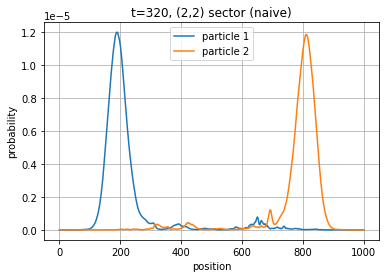

In [54]:
psi_nn = np.nan_to_num(psi)
plt.plot([np.sum(abs(psi_nn[i,:,1,1])**2) for i in range(psi.shape[0])], "C0-", label="particle 1")
plt.plot([np.sum(abs(psi_nn[:,i,1,1])**2) for i in range(psi.shape[1])], "C1-", label="particle 2")
plt.legend()
plt.title(f"t={t}, (2,2) sector (naive)")
plt.xlabel("position")
plt.ylabel("probability")
plt.grid()

### Fourier transform (naive)

In [55]:
freqs = fft.fftfreq(psi.shape[0]) * (2*np.pi)

freqs = fft.fftshift(freqs)
psi_ = np.nan_to_num(psi)
nrm = la.norm(psi_)
psik = fft.fft2(psi_, axes=(0,1))
psik *= nrm/la.norm(psik)

psik = fft.fftshift(psik, axes=(0,1))

(-0.6, 0.6)

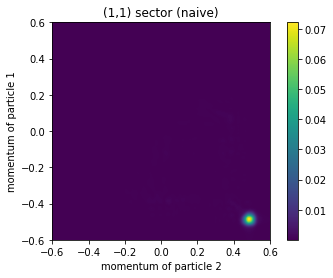

In [56]:
plt.imshow(abs(psik[:,:,0,0]), origin='lower', extent=[freqs[0], freqs[-1], freqs[0], freqs[-1]])
plt.title("(1,1) sector (naive)")
plt.xlabel("momentum of particle 2")
plt.ylabel("momentum of particle 1")
plt.colorbar()
plt.xlim(-0.6,0.6)
plt.ylim(-0.6,0.6)

(-0.6, 0.6)

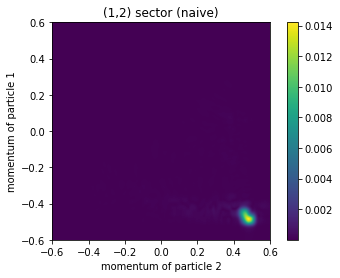

In [57]:
plt.imshow(abs(psik[:,:,0,1]), origin='lower', extent=[freqs[0], freqs[-1], freqs[0], freqs[-1]])
plt.title("(1,2) sector (naive)")
plt.xlabel("momentum of particle 2")
plt.ylabel("momentum of particle 1")
plt.colorbar()
plt.xlim(-0.6,0.6)
plt.ylim(-0.6,0.6)

(-0.6, 0.6)

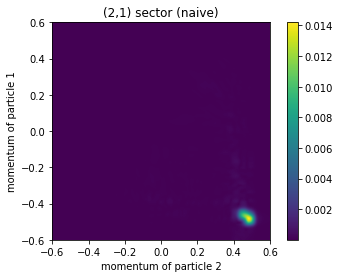

In [58]:
plt.imshow(abs(psik[:,:,1,0]), origin='lower', extent=[freqs[0], freqs[-1], freqs[0], freqs[-1]])
plt.title("(2,1) sector (naive)")
plt.xlabel("momentum of particle 2")
plt.ylabel("momentum of particle 1")
plt.colorbar()
plt.xlim(-0.6,0.6)
plt.ylim(-0.6,0.6)

(-0.6, 0.6)

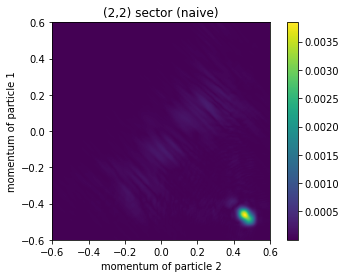

In [59]:
plt.imshow(abs(psik[:,:,1,1]), origin='lower', extent=[freqs[0], freqs[-1], freqs[0], freqs[-1]])
plt.title("(2,2) sector (naive)")
plt.xlabel("momentum of particle 2")
plt.ylabel("momentum of particle 1")
plt.colorbar()
plt.xlim(-0.6,0.6)
plt.ylim(-0.6,0.6)

In [60]:
1 - la.norm(np.nan_to_num(psi))**2  # projection error (probability)

0.7953390712598252

Mod over position, leaving separation.

In [61]:
nrms_allseps = olaps.nrms_by_sep(psi)

In [62]:
nrms_allseps.shape

(1001, 2, 2)

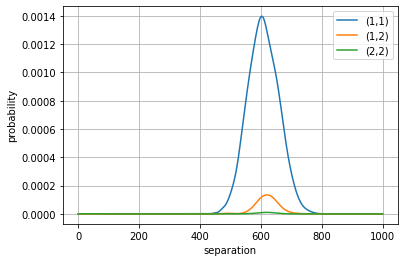

In [63]:
plt.plot(nrms_allseps[:,0,0]**2, label="(1,1)")
plt.plot(nrms_allseps[:,0,1]**2, label="(1,2)")
plt.plot(nrms_allseps[:,1,1]**2, label="(2,2)")
plt.xlabel("separation")
plt.ylabel("probability")
plt.legend()
plt.grid()

## Now handle momentum dependence

In [64]:
ex_specs_L = [(-(mom), 0), (-(mom+0.04), 0), (-(mom-0.04), 0)] # we compute overlaps with excitation tensors for a few different momenta
ex_specs_R = [(mom, 0),  (mom+0.04, 0),  (mom-0.04, 0)]

In [65]:
psi_11, _, sL_11, sR_11, BLs_11, BRs_11 = olaps.overlap_2p_components_specs(
  state, vac, ex_specs_L, ex_specs_R, ortho=True,
  brute=True, force_pseudo=True, verbose=False,
  return_prep_data=True)

Save everything:

In [66]:
psi_fn_comp = simdir + f"psi_comp_2p_11_basis_t{t}.npz"
np.savez_compressed(psi_fn_comp,
                  psi=psi_11, ex_specs_L=ex_specs_L, ex_specs_R=ex_specs_R,
                  BLs=BLs_11, BRs=BRs_11,
                  lL=sL_11.l[0], AL=sL_11.A[0], AC=vac.A[0], AR=sR_11.A[0], rR=sR_11.r[0])

In [67]:
psi_11_nn = np.nan_to_num(psi_11)

In [68]:
la.norm(np.nan_to_num(psi_11))

0.6980485183231049

Let's plot the (still naive) position wavefunction for the momentum 0.4 tensors:

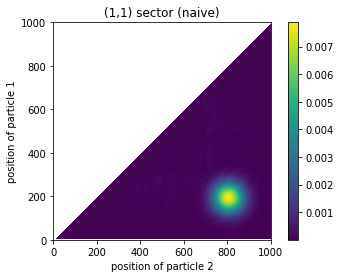

In [69]:
plt.imshow(abs(psi_11[:,:,0,0]), origin='lower')
plt.title("(1,1) sector (naive)")
plt.xlabel("position of particle 2")
plt.ylabel("position of particle 1")
plt.colorbar()

Now the next component (which will be small due to orthonormalization).

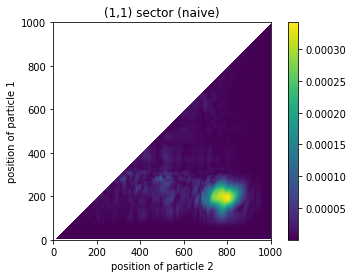

In [70]:
plt.imshow(abs(psi_11[:,:,0,1]), origin='lower')
plt.title("(1,1) sector (naive)")
plt.xlabel("position of particle 2")
plt.ylabel("position of particle 1")
plt.colorbar()

## Actual Fourier-mode projection

We use the data collected above, using a few momentum tensors, to parameterize the momentum-dependence on a fine grid (currently N momenta between -pi and pi, where N is the number of lattice sites in the sim. window).

This will take a while, as excitation tensor are computed for each of the N momenta.

In [71]:
res = olaps.get_overlaps_fourier(
    psi_11, sL_11, BLs_11, vac, BRs_11, sR_11,
    0, # left excitation level (adjust to match sector)
    0, # right excitation level (adjust to match sector)
    d_min=0, zero_tol=1e-6)

(1001, 1001, 3, 3) 0.4872717339330821 0.4872717339330821


In [72]:
P_proj, P_red, P_sep, P_psi, psi_red, freqs_nonzero_L, freqs_nonzero_R, Bs_p_basis_L, Bs_p_basis_R = res

In [73]:
np.savez(simdir + f"psi_fourier_2p_11_basis_t{t}.npz", fL=freqs_nonzero_L, fR=freqs_nonzero_R, probs=res[:4], Bs_p_basis_L=Bs_p_basis_L, Bs_p_basis_R=Bs_p_basis_R)

In [74]:
P_psi # Raw probability including all excitation tensors.
# This is typically an overestimate, as the basis is capable of representing excitations in other sectors too.

0.4872717339330821

In [75]:
P_sep  # After dropping poorly-separated terms

0.4872717339330821

In [76]:
P_proj  # This is the final probability after accounting for momentum dependence.

0.4784141446485083

In [77]:
la.norm(psik[:,:,0,0])**2  # Single-tensor (naive) probability of (1,1) from previous computation

0.1800606272490514

In [78]:
psi_red.shape

(144, 131)

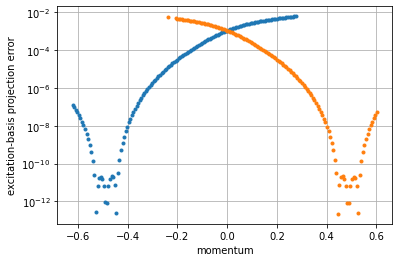

In [79]:
plt.semilogy(freqs_nonzero_L, 1-la.norm(Bs_p_basis_L, axis=2)[:,0], ".")
plt.semilogy(freqs_nonzero_R, 1-la.norm(Bs_p_basis_R, axis=2)[:,0], ".")
plt.xlabel("momentum")
plt.ylabel("excitation-basis projection error")
plt.grid()

Projections are very accurate for momenta close to +/- 0.5. Also not too bad beyond.

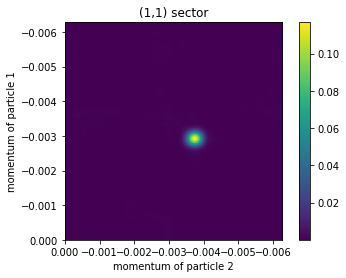

In [80]:
# NOTE: assuming here, for plotting purposes, that freqs_nonzero_X is continuous and sorted
plt.imshow(abs(psi_red), origin='lower',
           extent=(freqs_nonzero_R[0], freqs_nonzero_R[-1], freqs_nonzero_L[0], freqs_nonzero_L[-1]))
plt.title("(1,1) sector")
plt.xlabel("momentum of particle 2")
plt.ylabel("momentum of particle 1")
plt.colorbar()
#plt.xlim(-0.5,0.5)
#plt.ylim(-0.5,0.5)

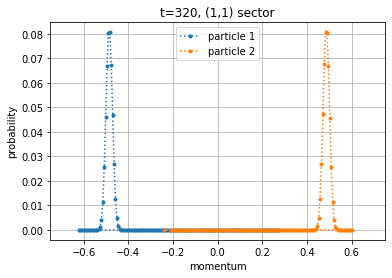

In [81]:
plt.plot(freqs_nonzero_L, [np.sum(abs(psi_red[i,:])**2) for i in range(psi_red.shape[0])], ".:", label="particle 1")
plt.plot(freqs_nonzero_R, [np.sum(abs(psi_red[:,i])**2) for i in range(psi_red.shape[1])], ".:", label="particle 2")
plt.legend()
plt.title(f"t={t}, (1,1) sector")
plt.xlabel("momentum")
plt.ylabel("probability")
plt.xlim(-0.75,0.75)
plt.grid()

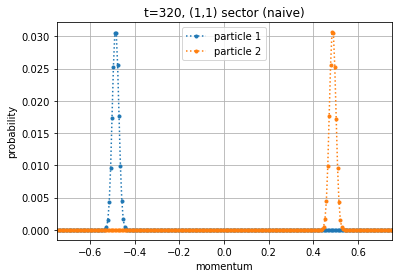

In [82]:
plt.plot(freqs, [np.sum(abs(psik[i,:,0,0])**2) for i in range(psik.shape[0])], ".:", label="particle 1")
plt.plot(freqs, [np.sum(abs(psik[:,i,0,0])**2) for i in range(psik.shape[1])], ".:", label="particle 2")
plt.legend()
plt.title(f"t={t}, (1,1) sector (naive)")
plt.xlabel("momentum")
plt.ylabel("probability")
plt.xlim(-0.75,0.75)
plt.grid()